In [1]:
import numpy as np
from random import random as rand
from math import floor
from numba import cuda

import matplotlib.pyplot as plt

# Optimization SN P Systems

In [14]:
threads_per_block = (32,32)
blocks_per_grid = (4,4)
H = 128
m = 128
runs = 250

In [15]:
# Defining 2 fitness functions:
# 1 is basic sum of components
# 2 is knapsack problem

def fitness(arr):
    return np.sum(arr)

omega = m*3
K = m
w = np.random.randint(1, omega, K)
p = w + 0.5*omega
C = 0.5*np.sum(w)

def fitness_knapsack(arr):
    knapsack = np.sum(np.multiply(arr, p))
    load = np.sum(np.multiply(arr, w))
    return knapsack if load <= C else -1

In [16]:
# prob matrix P => chromosome matrix T
# serial version

def spike(P):
    T = np.zeros((H, m))
    for i in range(H):
        for j in range(m):
            if (rand() < P[i,j]):
                T[i,j] = 1
                
    return T

In [17]:
# prob matrix P => chromosome matrix T
# serial version

@cuda.jit
def parallel_spike(P,Rand,T):
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    
    # Set as squares
    block_size = cuda.blockDim.x
    grid_size = cuda.gridDim.x    
    
#     start = tx + ty * block_size
#     stride = block_size * grid_size
    x = block_size * bx + tx
    y = block_size * by + ty
    
#     for i in range(start, P.shape[0], stride):
#         for j in range(start,P.shape[0],stride):
    T[x,y] = 1 if Rand[x,y] < P[x,y] else 0

In [18]:
# generate fitness vector of chromosomes
# return the most fit chromie

def fitness_vector(T):
    F = [fitness_knapsack(T[i]) for i in range(H)]
    return F

def fitness_argmax(F):
    arg = 0
    for i in range(1, H):
        arg = i if F[i] > F[arg] else arg
    return arg

In [19]:
# chromosome matrix T, prob matrix P, fitness vector F => new prob matrix P
# serial version

def guide(T, P, F, F_argmax):
    for i in range(H):
        for j in range(m):
            if (rand() < a[j]):
                k1, k2 = i, i
                while (k1 == i or k2 == i):
                    k1, k2 = [floor(rand() * H) for i in range(2)]
                b = T[k1,j] if F[k1] > F[k2] else T[k2,j]
                P[i,j] = P[i,j] + delta if b > 0.5 else P[i,j] - delta
            else:
                P[i,j] = P[i,j] + delta if T[F_argmax,j] > 0.5 else P[i,j] - delta
            
            # Adjustments
            if P[i,j] > 1:
                P[i,j] -= delta
            if P[i,j] < 0:
                P[i,j] += delta
    return P

In [20]:
@cuda.jit
def parallel_guide(T, P, F, F_argmax, a, delta, Rand1, Rand2, Rand3):

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    
    # Set as squares
    block_size = cuda.blockDim.x
    grid_size = cuda.gridDim.x    
    
#     start = tx + ty * block_size
#     stride = block_size * grid_size
    x = block_size * bx + tx
    y = block_size * by + ty 

    if(Rand1[x,y] < a[y]):
        k1 = (int)(Rand2[x,y]*H)
        k2 = (int)(Rand3[x,y]*H)
        b = T[k1,y] if F[k1] > F[k2] else T[k2,y]
        P[x,y] = P[x,y] + delta if b > 0.5 else P[x,y] - delta
    else:
        P[x,y] = P[x,y] + delta if T[F_argmax,y] > 0.5 else P[x,y] - delta
        
    if P[x,y] > 1:
        P[x,y] -= delta
    if P[x,y] < 0:
        P[x,y] += delta

## Serial

In [47]:
# Define the initial probability array and learning rate
P = np.random.random_sample((H, m))
a = 0.15 * np.random.random_sample(m) + 0.05
delta = 0.015 * rand() + 0.005

In [33]:
# game loop
# initial fitness

T = spike(P)
F = fitness_vector(T)

ave_fitness = []
ave_fitness.append(np.mean(F))

max_fitness = []
max_fitness.append(np.max(F))

In [34]:
for r in range(runs):
    guide(T, P, F, fitness_argmax(F))
    T = spike(P)
    F = fitness_vector(T)
    ave_fitness.append(np.mean(F))
    max_fitness.append(np.max(F))

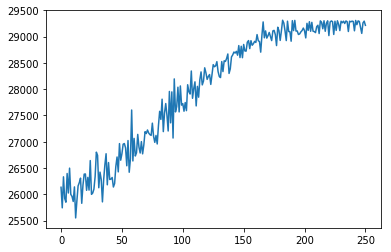

In [35]:
plt.plot(np.arange(runs+1), max_fitness)

## Parallel

In [55]:
# Define the initial probability array and learning rate
P = np.random.random_sample((H, m))
P_device = cuda.to_device(P)

a = 0.15 * np.random.random_sample(m) + 0.05
a_device = cuda.to_device(a)
delta = 0.015 * rand() + 0.005

In [56]:
# game loop
# initial fitness

T = np.zeros((H,m))
T_device = cuda.to_device(T)
R1 = np.random.random_sample((H, m))
R1_device = cuda.to_device(R1)

parallel_spike[blocks_per_grid, threads_per_block](P_device,R1_device,T_device)
F = fitness_vector(T_device.copy_to_host())

ave_fitness = []
ave_fitness.append(np.mean(F))

max_fitness = []
max_fitness.append(np.max(F))

In [57]:
for r in range(runs):
    R1 = np.random.random_sample((H, m))
    R1_device = cuda.to_device(R1)
    R2 = np.random.random_sample((H, m))
    R2_device = cuda.to_device(R2)
    R3 = np.random.random_sample((H, m))
    R3_device = cuda.to_device(R3)
    R4 = np.random.random_sample((H, m))
    R4_device = cuda.to_device(R4)

    F_argmax = fitness_argmax(F)
    F_device = cuda.to_device(F)
    parallel_guide[blocks_per_grid, threads_per_block](T_device,P_device,F_device,F_argmax,a_device,delta,R2_device,R3_device,R4_device)
    parallel_spike[blocks_per_grid, threads_per_block](P_device,R1_device,T_device)

    F = fitness_vector(T_device.copy_to_host())
    ave_fitness.append(np.mean(F))
    max_fitness.append(np.max(F))

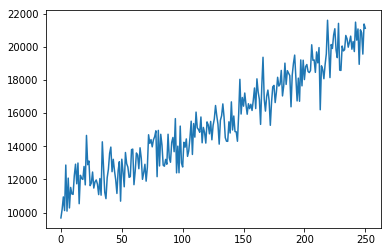

In [59]:
plt.plot(np.arange(runs+1), ave_fitness)